Universidade Federal de Santa Catarina<br>
Departamento de Engenharia Elétrica e Eletrônica<br>
EEL410250 / EEL7513 / EEL7514 - Aprendizado de Máquina
$\newcommand{\bX}{\mathbf{X}}$
$\newcommand{\bw}{\mathbf{w}}$
$\newcommand{\bW}{\mathbf{W}}$
$\newcommand{\bb}{\mathbf{b}}$
$\newcommand{\ba}{\mathbf{a}}$
$\newcommand{\by}{\mathbf{y}}$
$\newcommand{\bx}{\mathbf{x}}$
$\newcommand{\bU}{\mathbf{U}}$
$\newcommand{\bu}{\mathbf{u}}$
$\newcommand{\RR}{\mathbb{R}}$
$\newcommand{\calS}{\mathcal{S}}$
$\newcommand{\bT}{\mathbf{T}}$
$\newcommand{\bV}{\mathbf{V}}$
$\newcommand{\bv}{\mathbf{v}}$
$\newcommand{\bG}{\mathbf{G}}$
$\newcommand{\bg}{\mathbf{g}}$
$\newcommand{\bZ}{\mathbf{Z}}$
$\newcommand{\bz}{\mathbf{z}}$
$\newcommand{\bmu}{\boldsymbol{\mu}}$

# Exercício 9: Clustering e Redução de Dimensionalidade

Neste exercício, você irá explorar dois problemas de aprendizado de máquina **não-supervisionado**: clustering, usando o algoritmo K-means; e redução de dimensionalidade, usando análise de componentes principais (PCA) e redes neurais autoencoders.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import os
!pip install wget
import wget

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

def plot_data_kmeans(X, labels=None, centroids=None, previous_centroids=None, voronoi=False):
    from scipy.spatial import Voronoi, voronoi_plot_2d
    if voronoi and centroids is not None:
        voronoi_plot_2d(Voronoi(centroids), show_points=False, show_vertices=False);
    if labels is None:
        plt.scatter(X[:,0], X[:,1], s=50)
    else:
        plt.scatter(X[:,0], X[:,1], c=labels, cmap=plt.cm.brg, s=50)
    if centroids is not None:
        if previous_centroids is not None:
            plt.scatter(previous_centroids[:,0], previous_centroids[:,1], c=range(centroids.shape[0]), 
                        cmap=plt.cm.brg, marker='X', s=200, linewidths=2, edgecolors='gray')
            for k in range(centroids.shape[0]):
                M = np.r_[previous_centroids[[k]], centroids[[k]]]
                plt.plot(M[:,0],M[:,1],'k-')
        plt.scatter(centroids[:,0], centroids[:,1], c=range(centroids.shape[0]), 
                    cmap=plt.cm.brg, marker='X', s=200, linewidths=2, edgecolors='k')
    gap = (X.max(axis=0) - X.min(axis=0))*0.05
    plt.axis(np.r_[X.min(axis=0)-gap, X.max(axis=0)+gap][[0,2,1,3]])
    return

def plot_data_pca(X, X_rec=None):
    plt.plot(X[:, 0], X[:, 1], 'bo', ms=8, mec='k', mew=0.5)
    if X_rec is not None:
        for x, x_rec in zip(X, X_rec):
            plt.plot([x[0], x_rec[0]], [x[1], x_rec[1]], 'k--', lw=1)
        plt.plot(X_rec[:, 0], X_rec[:, 1], 'ro', ms=8, mec='k', mew=0.5)
    plt.axis('scaled')
    return

def display_images(X, n_cols=10, max_n_rows=6, scale=1.5):
    m, n = X.shape
    d = int(np.round(np.sqrt(n)))
    assert n == d**2
    n_rows = min(int(np.ceil(m/n_cols)), max_n_rows)
    plt.figure(figsize=(n_cols*scale, n_rows*scale))
    for i in range(min(m, n_rows*n_cols)):
        plt.subplot(n_rows, n_cols, i+1)
        plt.imshow(X[i].reshape(d,d), cmap=plt.cm.gray);
        plt.axis('off');
    return

# Clustering com K-Means

## 1. Conjunto de dados #1

Inicialmente, nosso objetivo é entender o funcionamento do algoritmo e como utilizar a função `sklearn.cluster.KMeans`. Para isso, utilizaremos um conjunto de dados sintético bem simples, o qual pode ser visualizado pelos comandos abaixo.

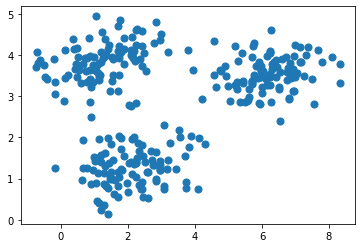

In [2]:
plot_data = plot_data_kmeans

from sklearn.datasets import make_blobs
X, _ = make_blobs(n_samples=300, n_features=2, centers=[[1, 1], [3, 3], [0.5, 3.8]], cluster_std=0.45, random_state=0)
X = X @ [[2, 0.2], [0.1, 1]]
plot_data(X)

1. Rode o algoritmo K-means com K=3 clusters partindo dos centróides iniciais dados abaixo e plote o resultado obtido (i.e., atribuição de clusters e respectivos centróides). Quantas iterações foram necessárias para convergência? Mostre também o valor final da função custo (soma dos quadrados de todas as distâncias aos respectivos centróides), chamado no `sklearn` de `inertia`.

#### Dicas
- Leia a documentação para entender como utilizar o `sklearn.cluster.KMeans`. Em particular, configure adequadamente os parâmetros `init` e `n_init` ao invés de usar seus valores padrão.
- Para plotar o resultado, utilize a função `plot_data(X, labels, centroids)`

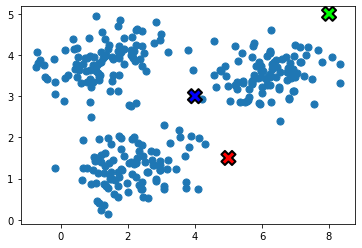

In [3]:
initial_centroids = np.array([[4, 3], [5, 1.5], [8, 5]])
plot_data(X, None, initial_centroids)

2. Repita o item anterior mostrando as atribuições de clusters, os centróides e o custo obtidos **a cada meia iteração** do algoritmo. Para isso, utilize a implementação própria do K-means fornecida abaixo. (Isso é necessário pois o `sklearn` não fornece os resultados obtidos a cada iteração.) Visualize os resultados variando o parâmetro `i` (iteração) da saída da célula com `@interact`. Confirme que o resultado após a última iteração é condizente com o resultado do item anterior.
3. (OPCIONAL) Escreva sua própria implementação das funções `update_centroids`, `update_labels` e `compute_inertia`.

#### Dicas
- Note que, na implementação abaixo (diferentemente do que está nos slides), a primeira parte da iteração corresponde ao cálculo dos centróides (a partir dos rótulos) e a segunda parte da iteração corresponde ao cálculo dos rótulos (a partir dos centróides).

In [ ]:
# own implementation
def update_centroids(X, labels, K):
    centroids = np.zeros((K, X.shape[1]))
    for k in range(K):
        centroids[k] = X[labels == k].mean(axis=0)
    return centroids

def update_labels(X, centroids):
    labels = ((X[:, None] - centroids[None, :])**2).sum(axis=2).argmin(axis=1)
    return labels

def compute_inertia(X, centroids, labels):
    if labels is None:
        return np.nan
    K = centroids.shape[0]
    inertia = 0
    for k in range(K):
        inertia += ((X[labels == k] - centroids[k])**2).sum()
    return inertia

def k_means(X, initial_centroids, max_iter=300):
    centroids = initial_centroids
    labels = None
    history = []
    K = centroids.shape[0]
    for i in range(max_iter):
        if i > 0:
            centroids = update_centroids(X, labels, K)
        previous_labels = labels
        labels = update_labels(X, centroids)
        history.append((centroids, labels))
        if np.all(labels == previous_labels):
            break
    return centroids, labels, history

In [ ]:
centroids, labels, result = k_means(X, initial_centroids)
result = [(None, None)] + result

from ipywidgets import interact
@interact(i=(0,len(result)-1, 0.5))
def _(i=0):
    first_half = (i % 1 == 0.5)
    i = int(i)
    if first_half:
        previous_centroids, labels = result[i]
        centroids, _ = result[i+1]
        plot_data(X, labels, centroids, previous_centroids)
        if i == 0:
            plt.title('Initial centroids')
        else:
            plt.title('Iteration {}: Update centroids'.format(i))
    else:
        centroids, labels = result[i]
        plot_data(X, labels, centroids, voronoi=True)
        if i == 0:
            plt.title('Original data')
        else:
            plt.title('Iteration {}: Update labels'.format(i))
    inertia = compute_inertia(X, centroids, labels)
    print('Inertia: {:g}'.format(inertia))

Daqui para frente, **ignore a implementação acima** e considere apenas a do `sklearn`.

4. Rode novamente o algoritmo do `sklearn`, mas agora com todas as configurações padrão (o que, em particular, envolve `n_init=10` reinicializações aleatórias com o método de inicialização `init='k-means++'`), e verifique se o algoritmo convergiu para uma solução semelhante (inclusive em termos de *inertia*). Quantas iterações foram necessárias?

## 2. Conjunto de dados #2

O próximo conjunto de dados é formado pelas cores dos pixels (no espaço RGB) da imagem abaixo:

100% [..............................................................................] 36556 / 36556
Image shape: (340, 510, 3)
Dataset shape: (173400, 3)


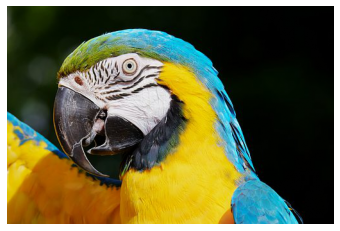

In [5]:
url = 'https://www.stoodi.com.br/wp-content/uploads/2019/02/araraa.jpg'
filename = 'arara.jpg'
if not os.path.exists(filename):
    wget.download(url, filename)
    print()
image = plt.imread(filename)/255
plt.imshow(image)
plt.axis('off');
print('Image shape:', image.shape)
X = image.reshape(-1, 3)
print('Dataset shape:', X.shape)

Note que cada pixel da imagem é interpretado como uma amostra num espaço tridimensional.

1. Rode o K-means para agrupar as cores dos pixels da imagem em K=16 clusters. Em seguida, substitua a cor de cada pixel da imagem pelo centróide do cluster correspondente e mostre as duas imagens lado a lado. 
1. Repita para vários valores de K e observe as diferenças.
1. (OPCIONAL) Experimente também com outras imagens à sua escolha.

#### Dica
- Para reduzir o tempo de treinamento, reduza para `n_init=1` o número de inicializações aleatórias.

Inertia: 1043.35
Wall time: 741 ms


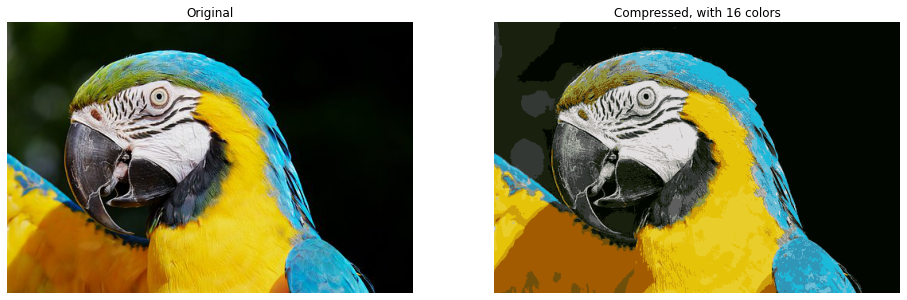

In [7]:
plt.figure(figsize=(16, 16))
plt.subplot(1,2,1)
plt.imshow(image)
plt.title('Original')
plt.axis('off');
plt.subplot(1,2,2)
plt.imshow(image_rec)
plt.title('Compressed, with {} colors'.format(K))
plt.axis('off');

## 3. Conjunto de dados #3

O próximo conjunto de dados é o MNIST e o objetivo é avaliar o desempenho do K-means para encontrar grupos de dígitos similares. Nesse caso, o espaço de atributos será formado pelos 784 pixels da imagem, um problema de dimensionalidade elevada. Para reduzir a complexidade, usaremos apenas um subconjunto das amostras.

In [8]:
from tensorflow.keras.datasets import mnist
(X, y) = mnist.load_data()[0]
X = X.reshape(X.shape[0], -1)/255
subset = np.random.RandomState(seed=0).choice(X.shape[0], size=10000)
X = X[subset]
y = y[subset]
print(X.shape, y.shape)

(10000, 784) (10000,)


Considere que o K-means será usado com K=10. Idealmente o algoritmo deve encontrar 10 clusters correspondendo exatamente aos 10 dígitos. Como os rótulos são conhecidos, é possível medir a acurácia do agrupamento tratando-o como um problema de classificação---a menos de uma permutação, pois o algoritmo de clustering não tem como adivinhar quais são os rótulos certos. Para fazer uma avaliação justa, você deve dar a um cluster o rótulo correspondente ao dígito que aparece com maior frequência no cluster. Por exemplo, se 90% das amostras do cluster 0 são dígitos 7, então você deve dar a todas as amostras desse cluster o rótulo 7, e assim por diante para todos os clusters (mesmo que haja repetição de rótulos atribuídos). Chamaremos de *acurácia do agrupamento* a acurácia resultante desse procedimento.

1. Aplique o K-means com K=10 e `n_init=5` (para garantir um desempenho melhor e menos aleatório) e analise os clusters encontrados. Para isso, calcule a [matriz de contingência](https://scikit-learn.org/stable/modules/clustering.html#contingency-matrix) (`sklearn.metrics.cluster.contingency_matrix`) utilizando `M = contingency_matrix(y, clustering_labels)`. Nessa notação, o elemento $(j,k)$ indica o número de amostras de rótulo $j$ que foram alocadas ao cluster $k$. Por exemplo, a primeira coluna corresponde ao cluster $k=0$ e seu $j$-ésimo elemento indica o número de dígitos $j$ que foram alocados a esse cluster.
1. Determine o melhor mapeamento entre clusters e rótulos, i.e., um array `best_map` cujo elemento $k$ contém o índice do valor máximo da coluna $k$. Note que pode haver valores repetidos. Em seguida, considerando este mapeamento, determine a acurácia do agrupamento obtido.

#### Dicas
- Na declaração da matriz de contingência dada acima, se o argumentos forem invertidos (`M = contingency_matrix(clustering_labels, y)`), a notação da matriz fica transposta.
- Caso você se confunda com o exemplo fornecido na documentação da matriz de contingência, segue uma explicação: no exemplo, há duas classes verdadeiras, "a" e "b", e o algoritmo de clustering encontrou os clusters 0, 1 e 2. O elemento (0,0) com valor 2 indica que 2 amostras que possuem rótulo verdadeiro 0 ( = "a") foram alocadas ao cluster 0. Podemos confirmar que isso é verdade observando os dois primeiros elementos dos vetores `x` (`true_labels`) e `y` (`clustering_labels`). (Obs: não confunda com o *nosso* `y`, que tem a interpretação de `true_labels`).

Cluster accuracy: 59.01%
Wall time: 2.62 s


3. Visualize os centróides de cada cluster. Indique no título de cada imagem o dígito predito para este cluster (i.e., o rótulo mais frequente) e sua frequência de ocorrência dentro do cluster. Para isso, execute o código abaixo. (Obs: os resultados vão variar com o `random_state` do K-Means.)

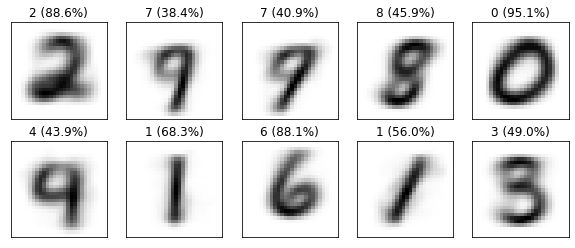

In [10]:
freq = np.diag(M[best_map])/M.sum(axis=0)
plt.figure(figsize=(10,4))
for k in range(10):
    plt.subplot(2, 5, k+1)
    plt.imshow(centroids[k].reshape(28,28), cmap=plt.cm.gray_r);
    plt.title('{} ({:.1%})'.format(best_map[k], freq[k]))
    plt.xticks([]);
    plt.yticks([]);

# Redução de dimensionalidade

## 4. Conjunto de dados #4

Para ganhar experiência com PCA vamos começar analisando um conjunto de dados bidimensional simples.

(50, 2)


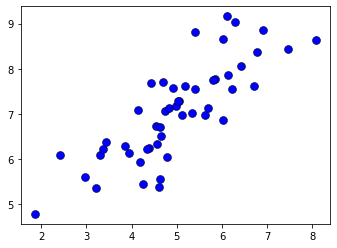

In [11]:
plot_data = plot_data_pca

rng = np.random.RandomState(seed=0)
a = 2*np.pi*(40/360)
X = [5,7] + rng.randn(50,2) @ np.diag([1.5,0.5]) @ [[np.cos(a), np.sin(a)], [-np.sin(a), np.cos(a)]]
plot_data(X)
print(X.shape)

1. Rode o algoritmo PCA (`sklearn.decomposition.PCA`) com $K=n=2$ e obtenha o vetor de média $\bmu$, os autovetores $\bg_1,\ldots,\bg_n$ e seus respectivos autovalores $\lambda_1,\ldots,\lambda_n$. Em seguida, trace setas partindo do ponto de média e indo na direção/sentido dos autovetores, com comprimento igual à raiz quadrada dos respectivos autovalores.

#### Dicas
- Leia a [documentação do PCA](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) e da função `plt.arrow`.
- Na álgebra linear, a convenção mais comum é tratar vetores como vetores-coluna. No entanto, para fins de programação, e em particular nas bibliotecas NumPy e sklearn, é mais conveniente trabalhar com vetores-linha. (Por exemplo, a $i$-ésima linha de uma matriz `X` pode ser obtida simplesmente como `X[i]`.) Em particular, a representação da matriz de autovetores no sklearn é a **transposta** da utilizada nos slides da aula. Assim, fique à vontade para trabalhar diretamente com a matriz $\bG^T$ (que pode ser atribuída, por exemplo, a uma variável `Gt`), a qual fornece os autovetores em suas linhas.

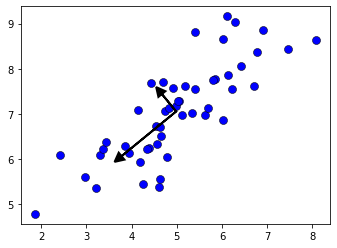

In [6]:
???

plot_data(X)
for i in range(2):
    plt.arrow(?, ?, ?, ?, 
              head_width=0.2, head_length=0.2, fc='k', lw=2, zorder=1000);

2. Projete os dados em $K=1$ dimensão, obtendo as coordenadas $\bz$ neste novo espaço (é mais fácil rodar o PCA novamente), e reconstrua os dados no espaço original ($n=2$) a partir destas coordenadas, i.e., aproxime os dados usando apenas a primeira componente principal. Em seguida, trace um gráfico ligando cada ponto original $\bx$ à sua projeção $\hat{\bx}$. Para isso, use a função `plot_data(X, X_rec)`.

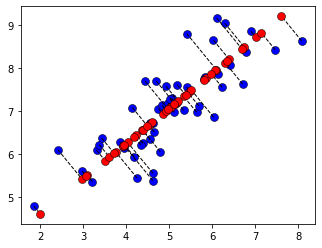

3. Treine uma rede neural autoencoder de 1 camada oculta com ativação linear e mostre que esse modelo é equivalente a um modelo PCA, no sentido de encontrar o mesmo subespaço gerado pelos componentes principais. Para isso, utilize uma única unidade na camada oculta e extraia os pesos do codificador através de `model.coefs_[0]`. Trace o gráfico desse vetor sobreposto ao conjunto de dados, assim como feito no item 1, e confirme que possui a mesma direção (não necessariamente o mesmo sentido ou magnitude) do primeiro componente principal. Lembre-se de centralizar (subtrair a média) do conjunto de dados antes de treinar a rede neural.

#### Dica:
- Utilize `sklearn.neural_network.MLPRegressor`.
- A camada oculta da rede neural produz a ativação $a = \bW^{[0]}\bx + b^{[0]}$, onde $\bW^{[0]} = [w_{11}^{[0]}, w_{12}^{[0]}]$, enquanto a saída da rede neural é dada por $\hat{\bx} = \bW^{[1]}a + \bb^{[1]}$, onde $\bW^{[1]} = [w_{11}^{[1]}, w_{21}^{[1]}]^T$ e $\bb^{[1]} = [b_{1}^{[1]}, b_{2}^{[1]}]^T$. Portanto, $\hat{\bx} = \bW^{[1]}(\bW^{[0]}\bx + b^{[0]}) + \bb^{[1]} = \bW^{[1]}\bW^{[0]}\bx + \bW^{[1]}b^{[0]} + \bb^{[1]}$. Como o conjunto de treinamento possui média nula, devemos esperar encontrar $\bW^{[1]}b^{[0]} + \bb^{[1]} = \mathbf{0}$, de forma que $\hat{\bx} = \bW^{[1]}\bW^{[0]}\bx$, com $\bW^{[1]}$ e $\bW^{[0]}$ fazendo o papel de $\bG$ e $(\bG^T\bG)^{-1}\bG^T$, respectivamente (note que as colunas de $\bW^{[1]}$ não são necessariamente uma base ortonormal). Confirme que essas identidades de fato são observadas. Note que o `sklearn` usa uma notação matricial transposta, portanto ${\bW^{[i]}}$ é obtido como `model.coefs_[i].T`.

## 5. Conjunto de dados #5

O próximo conjunto de dados é uma versão redimensionada do conjunto [LFWcrop](https://conradsanderson.id.au/lfwcrop/) e consiste de imagens de faces com dimensões 32 x 32 em escala de cinza. O conjunto já está "achatado" em vetores de comprimento $n=1024$. 

In [14]:
import h5py
filename = 'faces.h5'
if not os.path.exists(filename):
    wget.download('https://github.com/danilo-silva-ufsc/ml/raw/master/data/' + filename)
with h5py.File(filename, 'r') as file:
    X = file['X'][:]
print(X.shape, X.dtype)

100% [..........................................................................] 5122048 / 5122048(5000, 1024) int8


Um exemplo das primeiras 50 imagens é mostrado a seguir.

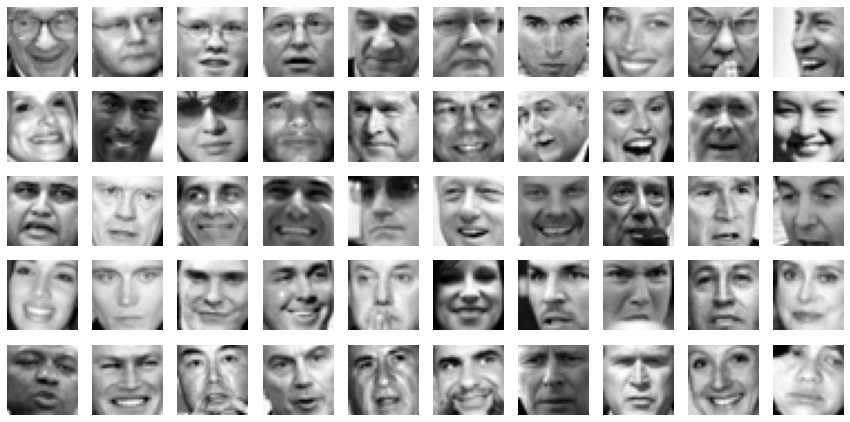

In [15]:
display_images(X[:50])

1. Rode o algoritmo PCA com K = 100 componentes. Visualize como uma imagem a média e os 39 primeiros componentes principais (em uma grade 4x10). Para isso, utilize a função `display_images`, que já efetua automaticamente a conversão para imagens e organiza em uma grade.

#### Dica
- Para incluir o vetor `m` como uma primeira linear adicional na matriz `A` você pode utilizar `np.r_[m.reshape(1, -1), A]`.

2. Ainda com K=100, transforme as imagens para o espaço de autovetores K-dimensional e em seguida as reconstrua no espaço original. Mostre a versão original e reconstruída das 10 primeiras imagens.

In [ ]:
X_rec = ???

from ipywidgets import interact
@interact(i=(0,9))
def _(i=0):
    display_images(X[10*i:10*i+10])
    display_images(X_rec[10*i:10*i+10])

3. Determine o número de componentes principais necessários para reter 99% da variância. Em seguida, trace um gráfico com a proporção de variância retida acumulada em função do número de componentes principais. (Obs: será um gráfico crescente.)

#### Dica
- Leia a documentação da função `PCA`.
- A função `scikitplot.decomposition.plot_pca_component_variance` implementa justamente o que é pedido nessa questão. Se quiser, você pode usá-la para confirmar se a sua solução está correta.

4. (OPCIONAL) Encontre e mostre as 20 imagens mais próximas (em distância euclidiana) da imagem `X[25]` (obs: há outras 28 imagens dessa mesma pessoa nesse conjunto.) Para isso, use a função `kneighbors` da classe `sklearn.neighbors.NearestNeighbors`. 

5. (OPCIONAL) Você acha que a extração de atributos via PCA pode fornecer uma representação melhor do que a original, no sentido de que a distância euclidiana no espaço transformado seja mais significativa (mais preditiva para tarefas de aprendizado) do que no espaço original? No caso específico de imagens, você consegue pensar em um modelo de extração de atributos melhor do que PCA?

## 6. Conjunto de dados #6

1. Refaça os itens 3.1 a 3.3 tendo antes pré-processado as imagens com PCA para reduzir sua dimensionalidade. O objetivo é acelerar o K-Means sem prejudicar significativamente os resultados. Meça a acurácia e o tempo decorrido na clusterização. Na medição de tempo decorrido, certifique-se de incluir o tempo para obter os centróides no espaço original de `X` (i.e., imagens).

#### Dicas:
- Como você vai calcular a acurácia do agrupamento múltiplas vezes, é conveniente escrever uma função `cluster_accuracy(y, clustering_labels)`.

In [18]:
from tensorflow.keras.datasets import mnist
(X, y) = mnist.load_data()[0]
X = X.reshape(X.shape[0], -1)/255
subset = np.random.RandomState(seed=0).choice(X.shape[0], size=10000)
X = X[subset]
y = y[subset]
print(X.shape, y.shape)

(10000, 784) (10000,)


In [ ]:
def cluster_accuracy(y, labels):
    ???
    return acc

In [21]:
import time

t0 = time.time()
model = KMeans(10, n_init=5, random_state=0).fit(X)
labels = model.labels_
centroids = model.cluster_centers_
dur_baseline = time.time() - t0
acc_baseline = cluster_accuracy(y, labels)
print('Baseline')
print('Cluster accuracy: {:.2%}'.format(acc_baseline))
print('Duration: {:g} seconds'.format(dur_baseline))

Baseline
Cluster accuracy: 59.01%
Duration: 2.76358 seconds


In [23]:
N = ???

t0 = time.time()
???
centroids = ???
dur = time.time() - t0
acc = cluster_accuracy(y, labels)
print('PCA with {} components'.format(N))
print('Cluster accuracy: {:.2%}'.format(acc))
print('Duration: {:g} seconds'.format(dur))

PCA with 20 components
Cluster accuracy: 58.59%
Duration: 0.702662 seconds


2. Trace um gráfico da acurácia e outro do tempo decorrido, ambos em função do número de componentes principais. Em torno de qual valor parece ser o número mais adequado de componentes para esta aplicação?

In [ ]:
%%time
Ns = np.arange(1,51)
accs = np.zeros(len(Ns))
durs = np.zeros(len(Ns))
for i, N in enumerate(Ns):
    t0 = time.time()
    ???
    centroids = ???
    durs[i] = time.time() - t0
    accs[i] = cluster_accuracy(y, labels)

In [ ]:
plt.xlabel('Number of PCA components')

plt.ylabel('Clustering accuracy')
lns = plt.plot(Ns, accs, 'b.-', label='accuracy');
plt.hlines(acc_baseline, Ns[0], Ns[-1], colors='b')
plt.grid()

plt.twinx()

plt.ylabel('Normalized clustering duration')
lns += plt.plot(Ns, durs/dur_baseline, 'r.--', label='duration');

plt.legend(lns, [ln.get_label() for ln in lns], loc='lower right');